# Classification of pitches

The goal here is to classify the types of pitches thrown by a given pitcher. Though the pitchfx data comes with pitch classfications, it is known to not be very reliable ("It is accurate enough for most work that involves differentiating between fastballs and off-speed pitches"--Fast, "What the heck is PitchFX?"). Additionally, clustering is a relatively simple task to perform with PitchFX and has a good chance to be able to separate pitches.

To start, we will link the relevant libraries.

In [4]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Gathering data

For our classification, we will choose one pitcher to examine. Let's choose 'Barry Zito', who we observed briefly in our EDA. He is known for the break of his curveball and a below-average fastball.

### Connecting to database

Let's specificy the database name and path, then connect to the database.

In [5]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

### Selecting pitches

We'll query our database to get all the pitches he threw in 2008.  Note that we will not worry about sorting the pitches by pitch number since we are just clustering pitches. Additionally, the *pitchfx* table does not have the pitcher id stored. Instead, we have to link the *pitchfx* table to the *events* table to get player id information. We'll print out the first five pitches.

In [6]:
query = """SELECT DISTINCT pitchfx.* 
    FROM pitchfx
    JOIN events ON (pitchfx.game_id=events.game_id
        AND pitchfx.prev_event=events.event_id)
    WHERE events.pitcher_id=(SELECT player_id
        FROM players
        WHERE players.player_first='Barry'
            AND players.player_last='Zito')
    ORDER BY game_id, pitch_num"""
bz_pfx = pd.read_sql_query(query, db)
bz_pfx.head()

,game_id,pitch_num,at_bat,time,prev_event,description,outcome,pre_balls,post_balls,pre_strike,...,vz0,ax,ay,az,break_y,break_angle,break_length,spin_dir,spin_rate,pitch_type
0,233769,30,4,134206.0,7,Ball,B,0,1,0,...,-4.167,-4.395,28.973,-13.125,23.7,16.5,3.9,192.990,2278.601,FC
1,233769,31,4,134217.0,7,Called Strike,S,1,1,0,...,-7.852,-1.776,29.654,-9.818,23.7,8.9,3.2,184.540,2620.543,FF
2,233769,32,4,134228.0,7,Foul,S,1,1,1,...,-2.479,3.593,22.606,-23.886,23.7,-8.3,9.2,156.564,1243.876,CH
3,233769,33,4,134247.0,7,"In play, no out",X,1,1,2,...,-5.803,-1.431,30.550,-8.798,23.7,12.1,2.8,183.501,2732.740,FF
4,233769,37,5,134336.0,8,Ball,B,0,1,0,...,-2.421,-3.625,31.828,-12.756,23.6,18.5,3.8,190.573,2300.700,FF


## Data cleaning and feature selection

The goal here is to classify pitches ourselves, as we saw from EDA that there are some apparent pitch misclassifications (for instance, some cutters seemed to be grouped with sliders when looking at movement information).

From EDA we saw that the pitch data for Barry Zito contains a number of Nans. Fortunately, the Nans appeared to be spread out throughout data observations (such they appear somewhat random over time and are unlikely to add any bias), and they were only present in 3% of the pitches. We could choose to impute some of the missing feature information for a given observation, but from EDA we saw that where there were Nans for a given pitch, nearly all of the trajectory features were missing. Therefore, we'll drop the pitches containing any Nans rather than try to fill them in based on only situational information.

In [7]:
# number of data points before
print("number of observations including nans: ", bz_pfx.shape[0])

# drop nans
bz_pfx = bz_pfx.dropna(axis=0, how="any")

# number of data points after
print("number of observations without nans: ", bz_pfx.shape[0])

number of observations including nans:  3206
number of observations without nans:  3102


From PCA, we saw that the first principal component (which explained 30% of the total variance in the data) was primarily a measure of pitch trajectory, while the subsequent components were measures of pitch location and situtational information (which explained less than 15% of the variance in the data each). Since the goal here is pitch classification, we will keep only trajectory features tied to the first principal component for clustering (which we saw from EDA). Note that we will keep `pitch_type` for now, as it contains the pitch classifications from the database.

Decriptions of these pitch variables can be found here: https://fastballs.wordpress.com/category/pitchfx-glossary.

In [41]:
# drop features
bz_pfxc = bz_pfx.drop(["game_id",
                       "pitch_num",
                       "at_bat",
                       "time",
                       "prev_event",
                       "description",
                       "outcome",
                       "pre_strike",
                       "post_strike",
                       "pre_balls",
                       "post_balls",
                       "sz_top",
                       "sz_bot",
                       "pz",
                       "px",
                       "x",
                       "y",
                       "y0",
                       "x0",
                       "z0",
                       "break_y"], 1)

While we saw from EDA that a number of features are highly correlated (e.g., `start_speed` and `end_speed`), we will keep them for now in our pitch clustering analysis.

## Clustering pitches

We will use clustering methods to classify pitches. This is an unsupervised learning technique, and we will need to interpret the resulting groups of clusters. We will comapre our classifications to those from the database.

### Based on features from intuition

Let's try hierarchical clustering since we do not want to assume that we know the number of clusters beforehand. All data points begin as their own cluster, in some ways. Then we fuse data points together that are similar to each other, and continue until all data points are in one cluster. There are some controls over how clusters are fused. There are five common types of linkage (complete, average, single, centroid, ward). There are also dissimilarity measures, such as Euclidean distance and correlation-based distances. For the case of pitch classification, we will start for Euclidean distance, as we're looking for feature values with similar values.

Start by importing the clustering object from scipy.

In [10]:
# import
import scipy.cluster.hierarchy as hier

Remember that we should standardize the features (mean 0, standard deviation 1) before clustering, as we do not want distances (here Euclidean) to be biased by one feature. We'll focus on just the three features from intuition (`start_speed`, `ax`, and `az`).  We'll avoid adding more features for now, as we would like to avoid the clustering problems associated with higher-dimensional data.

In [98]:
# subset of pitches
pitches_intuit = bz_pfxc[["ax",
                          "az",
                          "start_speed"]]

Now let's perform hierarchical clustering on the data. We'll use the Ward variance minimization algorithm for the linkage, which treats the analysis as a variance problem rather than similarity problem.

In [99]:
# generate linkage matrix
hclust_comp = hier.linkage((pitches_intuit-pitches_intuit.mean())/pitches_intuit.std(),
                           method='ward',
                           metric='euclidean')

Now let's plot the corresponding dendrogram, colored by a cutoff of 25.

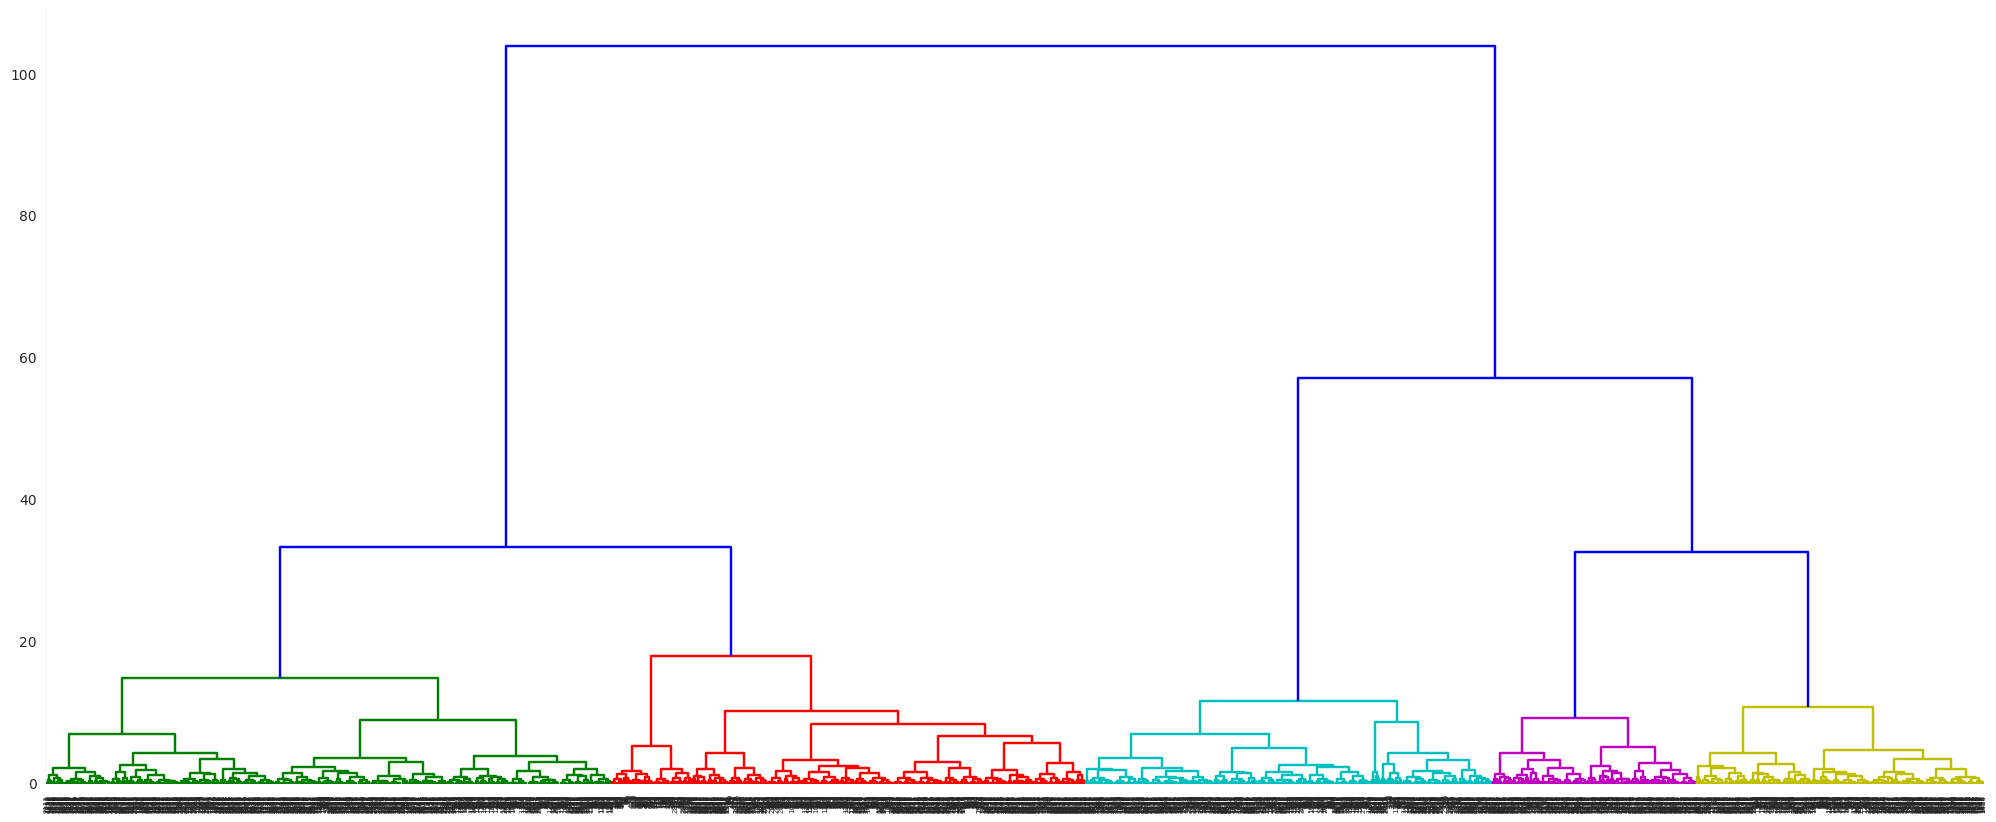

In [101]:
# plot the dendrogram colored by a certain height
hcut = 25
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_comp,
                        color_threshold=hcut,
                        leaf_rotation=90)

We see that with this clustering, we get 5 clear clusters. Let's project the cluster classification back onto our original feature axes using a crossplot function.

In [16]:
# create function for cross plots
def xplot3(dataframe3, ax0, ax1, ax2, *label):
    """Create crossplots of over three variables
    
    Input:
        dataframe3: pd dataframe
        ax0: feature string 1
        ax1: feature string 2
        ax2: feature string 3
        label: optional color label (if not specified then plots the third axis)
        
    Outputs:
        crossplots over all combinations of three features
    """
    # check if color label
    if label:
        col = [label[0] for ii in range(3)]
    else:
        col = [dataframe3[ax2], dataframe3[ax0], dataframe3[ax1]]

    # initialize subplots and feature vector
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    axes = [ax0, ax1, ax2, ax0, ax1]
    
    # loop over figures
    for ii in range(3):
        pp = ax[ii].scatter(dataframe3[axes[ii]],
                            dataframe3[axes[ii+1]],
                            c=col[ii],
                            cmap="jet",
                            alpha=0.2)
        ax[ii].set_xlabel(axes[ii])
        ax[ii].set_ylabel(axes[ii+1])
        if label:
            plt.colorbar(pp, ax=ax[ii])
        else:
            plt.colorbar(pp, ax=ax[ii], label=axes[ii+2])
    
    plt.show()
    
    # clean up
    return

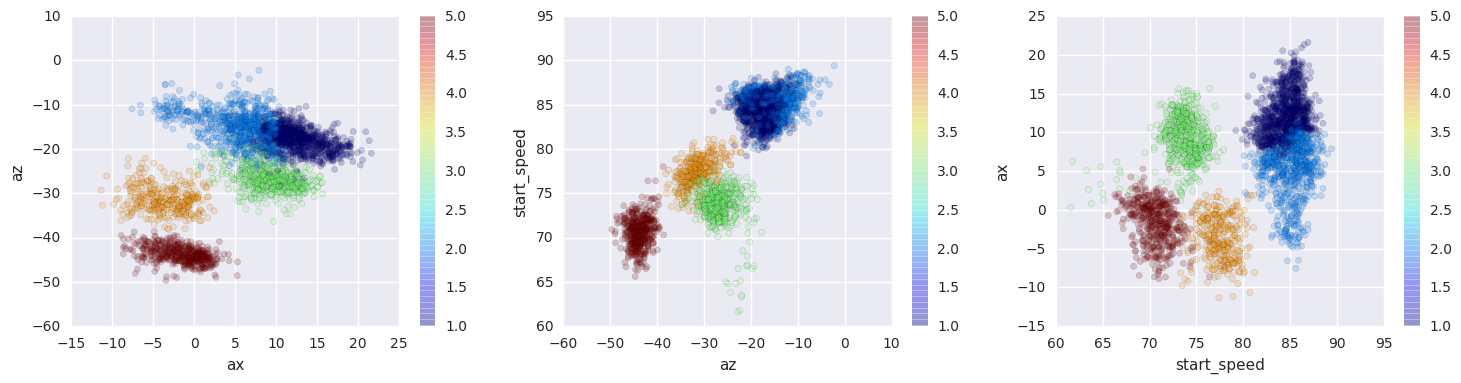

In [102]:
# labels
hlabel = hier.fcluster(hclust_comp, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel)

We can see that the clusters look reasonable. Interestingly, the large cluster at the highest velocities got broken into two. Based on the feature values associated with each of these clusters, the light blue group is likely his four-seam fastball, the dark blue cluster is likely his two-seam fastball (which tails from left to right), the green cluster is likely his changeup, the orange cluster is likely his slider (breaks right to left), and his red cluster is likely his notorious curveball.

These pitch classification descriptions are based on the pitch chart in https://www.fangraphs.com/library/pitch-type-abbreviations-classifications/ (flip for left-handed pitchers).

Let's compare our results to the pitch classifications from our database.

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


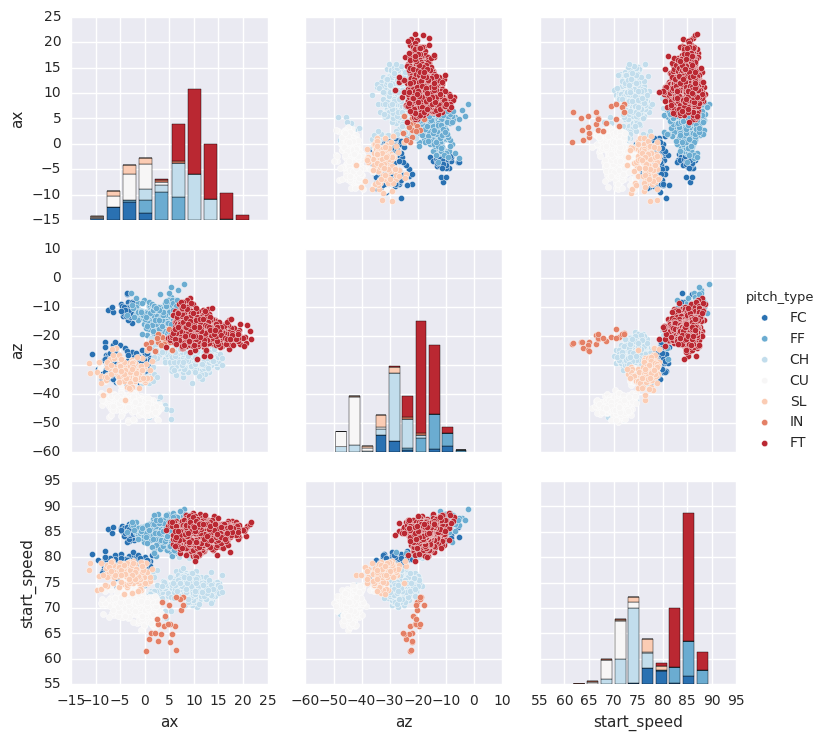

In [20]:
## pitch type from database
#pclass = pitch_info["pitch_type"].astype('category').cat.codes
#
## project label onto data points
#plt.scatter(pitches["ax"], 
#            pitches["start_speed"], 
#            c=pclass, 
#            cmap="jet",
#            alpha=0.5)
#plt.xlabel("Horizontal acceleration (ft/s2)")
#plt.ylabel("Start speed (mph)")
#plt.show()

# pitch type from database
pitches_intuit["pitch_type"] = bz_pfxc["pitch_type"]
sns.pairplot(data=pitches_intuit,
             hue="pitch_type",
             palette="RdBu_r")
plt.show()

As we can see, the pitch classifications here are quite different from our pitch classification. Looking at `ax` vs `start_speed`, we can see that the cutter (blue) is found in both the primary clusters for the four-seamer (green-blue) and the slider (pink). While it is possible that the cutter does exist, it is difficult to believe that it is also that similar to his slider. Therefore, it looks like our clustering algorithm might be doing a better job than what was provided by PitchFX, although with one fewer pitch type.

However, since the data base suggests that there are six pitch types, let's actually go back and pull out the sixth cluster from our hierarchical clustering and see what we get.

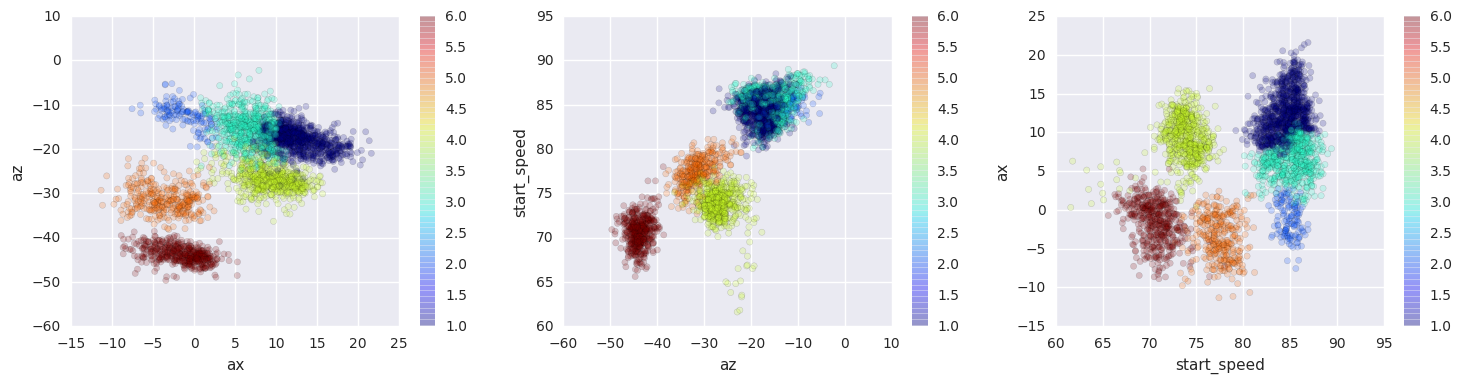

In [22]:
# labels
hcut = 18
hlabel = hier.fcluster(hclust_comp, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel)

With six clusters, we actually see the probable cutter being separated (light blue). It has similar horizontal acceleration as the slider and curveballs but has velocity comparable to his two other fastballs.

Therefore, we are confident that Barry Zito has five pitches (four-seam, two-seam, changeup, slider, curveball), and potentially a sixth pitch (cutter) with less confidence. Overall, these appear to be better classifications than those from the database, as we do not have multiple pitches grouped into the same cluster (like the database shows when plotting horizontal acceleration against start speed).

### Based on trajectory features

Now let's look at our clustering results when all the trajectory features are included. We'll run the same workflow as before using ward linkage and euclidean distance.

In [245]:
# generate linkage matrix
hclust_intuit = hier.linkage((bz_pfxc.iloc[:, :-1]-bz_pfxc.iloc[:, :-1].mean())/bz_pfxc.iloc[:, :-1].std(),
                           method='ward',
                           metric='euclidean')

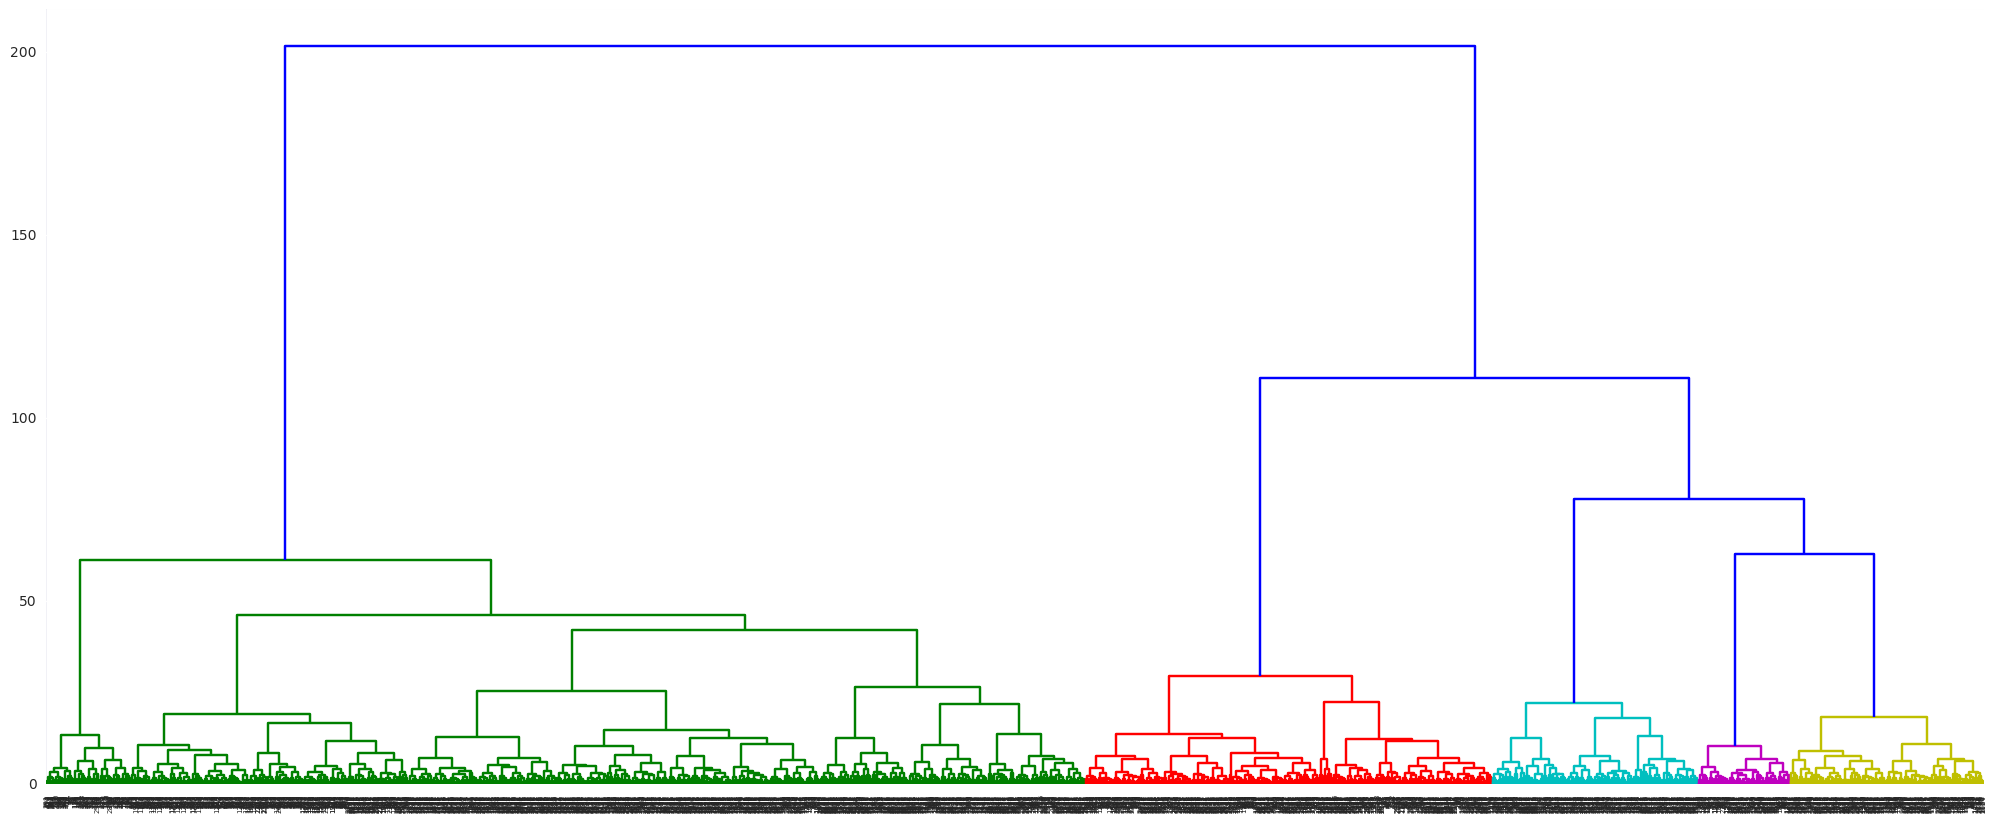

In [246]:
# plot the dendrogram colored by a certain height
hcut = 62
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_intuit,
                        color_threshold=hcut,
                        leaf_rotation=90)

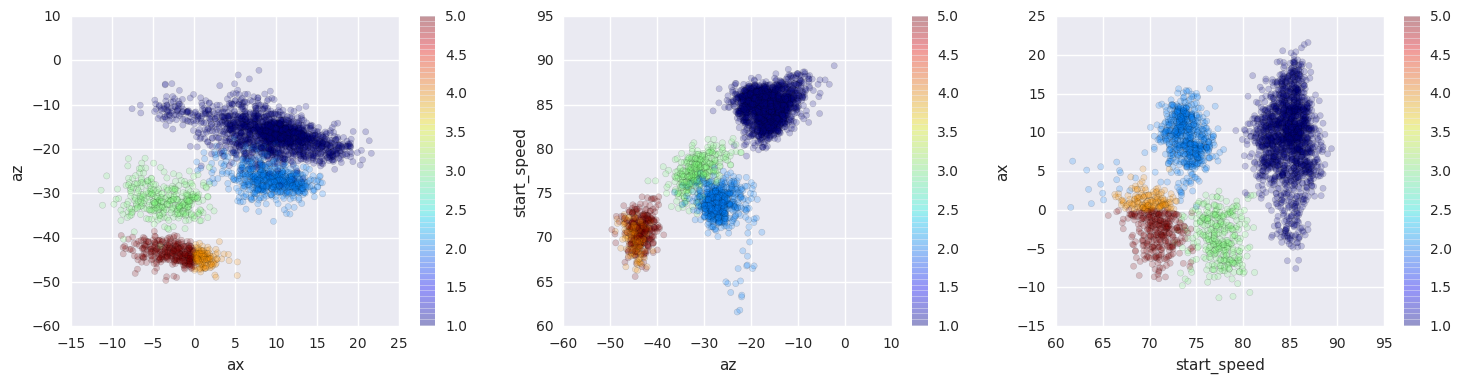

In [247]:
# labels
hlabel = hier.fcluster(hclust_intuit, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel)

We can see that when using all features, we acutally get some clear clusters. However, when trying to distinguish a fifth cluster, we see that the curveball cluster (red) is actually spilt into two clusters. Compared to the labels from the dataset and the clustering results using our intuition, it is unlikely that this particular cluster should be split in two.

We are likely being plagued by the curse of dimensionality, where data points become more spread out in higher dimensions and appear "less similar" to each other. Thus, any clustering algorithm based on a distance metric will be negatively impacted, as it will be less clear how to group observations together.

### Based on PCA space 

Next, instead of throwing all the features into a clustering algorith, we will look to reduce the number of dimensions in the data first. This is because we want to avoid the curse of dimensionality, which we saw in action in the previous section.

We will use PCA to find a lower-dimensional representation of the data that explains as much of the variance as possible. PCA should also allow us to get around the problems from using highly-correlated features.

In [167]:
# import pca
from sklearn.decomposition import PCA

# standardize features
bz_pfxc_stand = (bz_pfxc.iloc[:, :-1]-bz_pfxc.iloc[:, :-1].mean())/bz_pfxc.iloc[:, :-1].std()

# initialize and perform pca
pca = PCA(whiten=False)
bz_pfxc_pca = pca.fit(bz_pfxc_stand)

Let's take a look of the proportion of variance explained by each principal component.

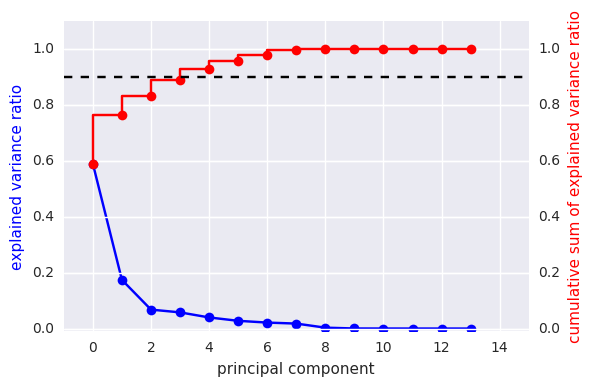

In [168]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(bz_pfxc_pca.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(bz_pfxc_pca.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 15])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

We see that the first two principal components already account for more than 75% of the variance in the data. Starting from the third principal component, there is a steep dropoff in the proportion of variance explained.

Let's now take a look at the loadings of the first four principal components to get a sense of which features they are most sensitive to.

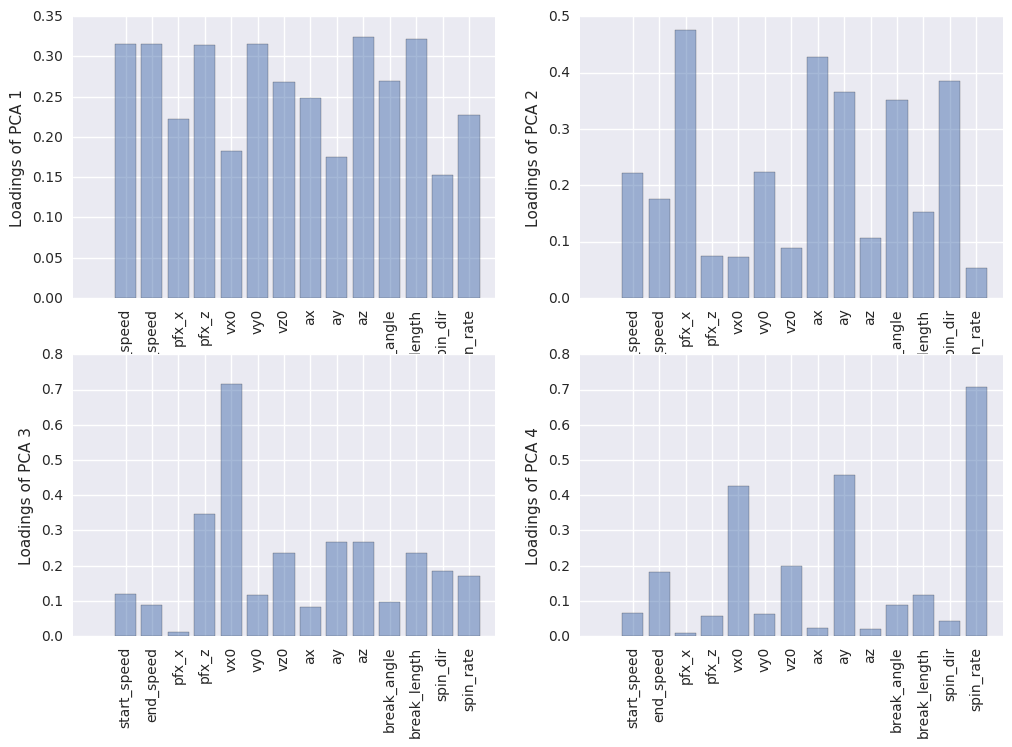

In [169]:
# intialize figure
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# plot loadings
for ii in range(2):
    for jj in range(2):
        loadings = bz_pfxc_pca.components_[2*ii+jj, :]
        # plot barchart of loadings
        ax[ii, jj].bar(range(len(loadings)), np.abs(loadings), align='center', alpha=0.5)
        ax[ii, jj].set_ylabel("Loadings of PCA %s" %(2*ii+jj+1))
        plt.sca(ax[ii, jj])
        plt.xticks(range(len(loadings)), list(bz_pfxc), rotation=90)
plt.show()

The first principal component is a measurement of mostly the velocity and vertical movement, the second is a measurement of primarily the horizontal movement, the third is a measurement of the horizontal velocity, and the fourth is a measurement of the spin rate.

We will perform hierarchical clustering using just the information from the first four principal components, so that nearly 90% of the variance in the data is explained.

In [170]:
# calculate the scores
bz_pfxc_pca_fit = np.dot(bz_pfxc_stand, bz_pfxc_pca.components_.T)

# scale the scores
bz_pfxc_pca_stand = (bz_pfxc_pca_fit-bz_pfxc_pca_fit.mean(axis=0))/bz_pfxc_pca_fit.std(axis=0)

In [248]:
# perform clustering on first four principal components
hclust_pc4 = hier.linkage(bz_pfxc_pca_stand[:, :4],
                          method='ward',
                          metric='euclidean')

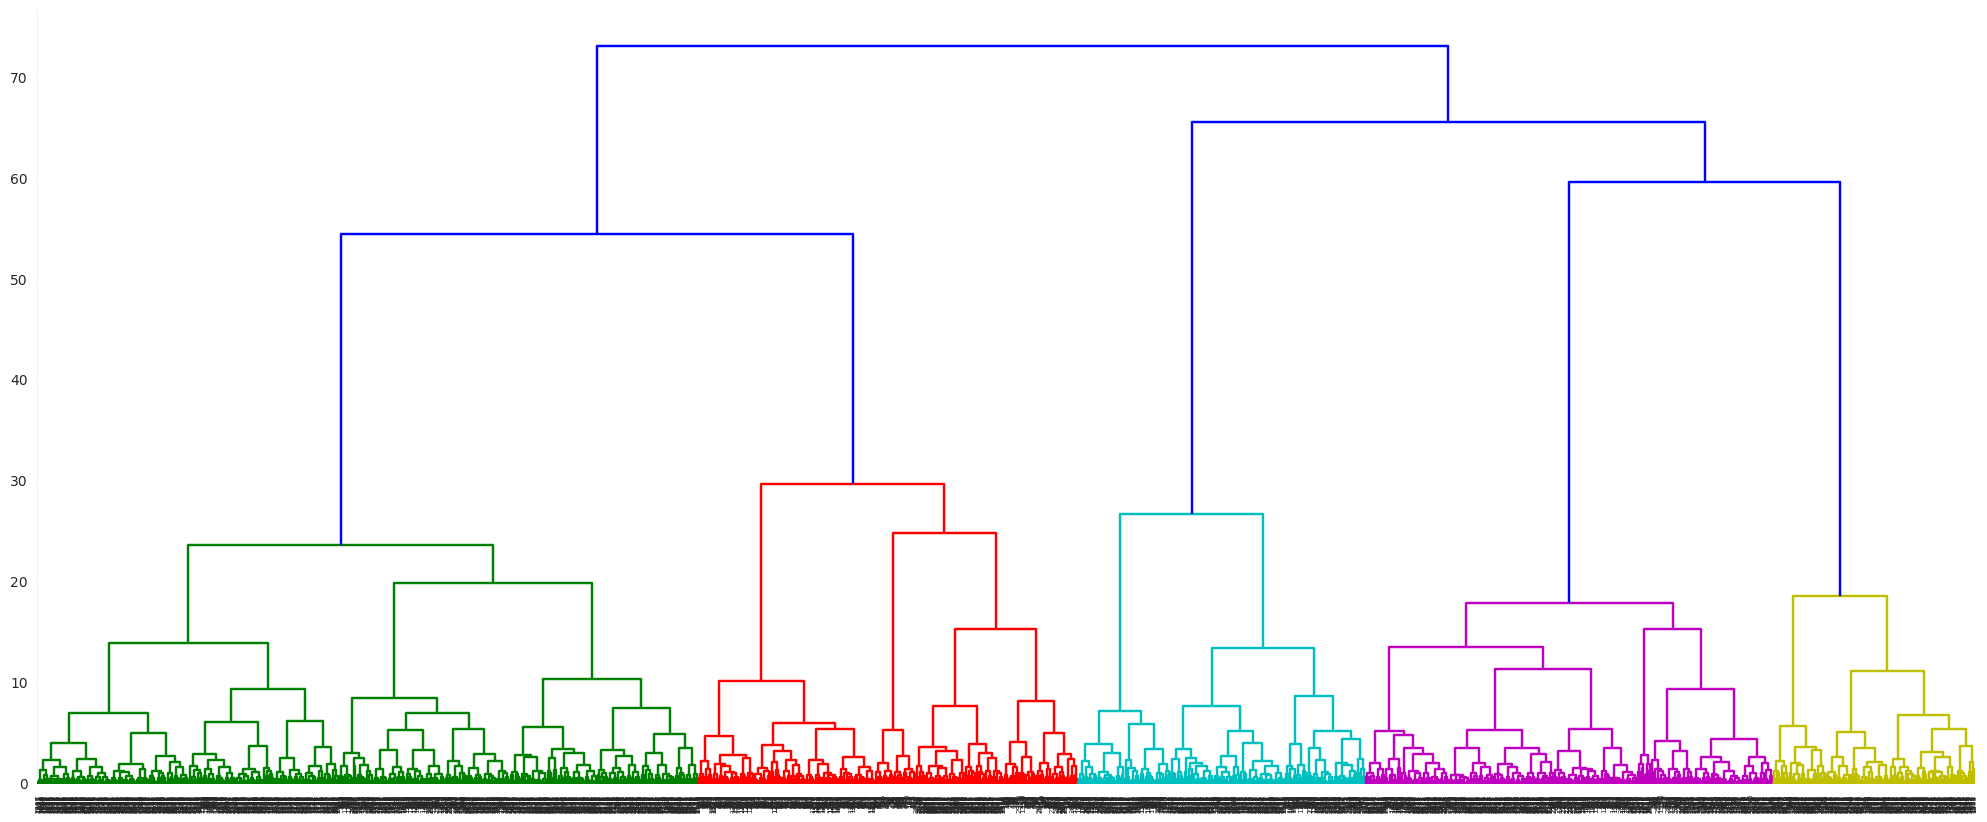

In [249]:
# plot the dendrogram colored by a certain height
hcut = 45
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_pc4,
                        color_threshold=hcut,
                        leaf_rotation=90)

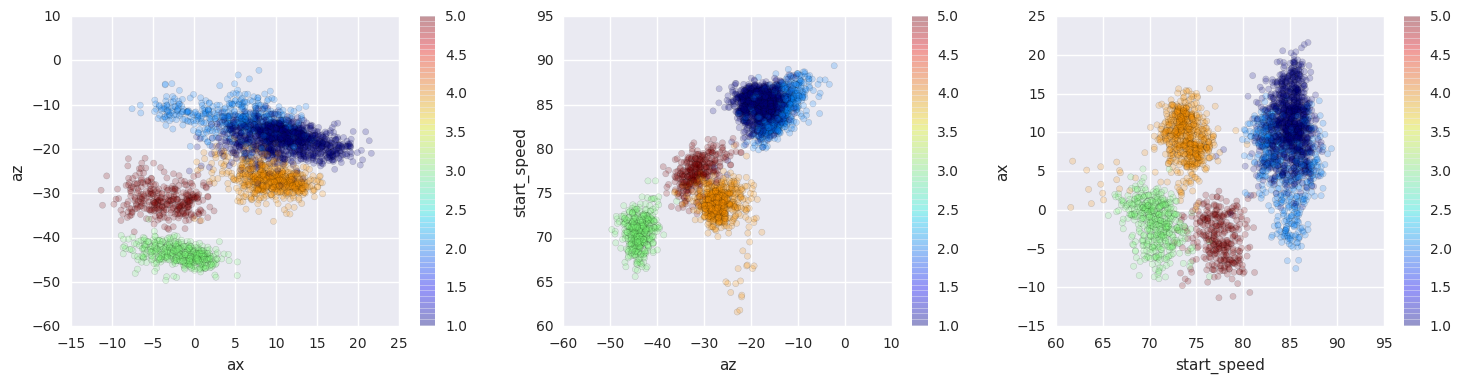

In [250]:
# get cluster labels
hlabel = hier.fcluster(hclust_pc4, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel)

We see that our clustering results in PCA space do a relatively good job finding five clusters. They appear to be the clusters related to the four-seamer, two-seamer, changeup, slider, and curveball. These are similar results when using our intution for selecting clustering features, although there is some difference in the ratio of four-seamers and two-seamers. Overall, it seems that PCA can be effective in reducing the dimension of our data for clustering purposes.

Let's look at how the clustering looks when using three principal components.

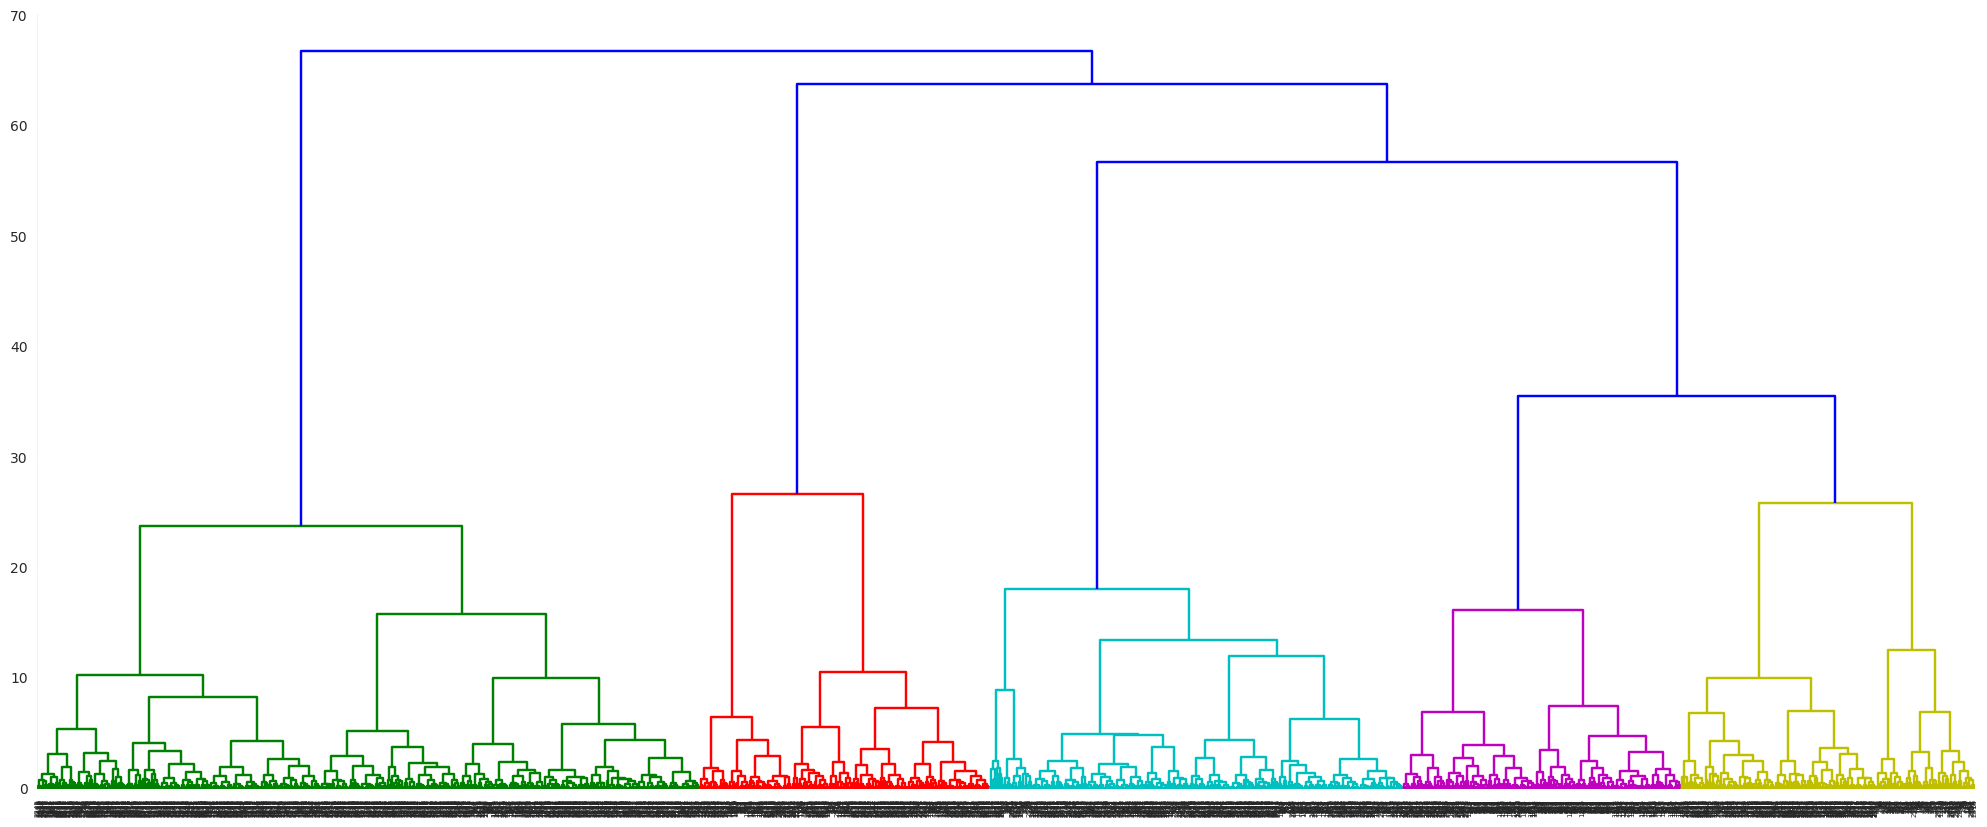

In [256]:
# perform clustering on first four principal components
hclust_pc3 = hier.linkage(bz_pfxc_pca_stand[:, :3],
                          method='ward',
                          metric='euclidean')

# plot the dendrogram colored by a certain height
hcut = 30
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_pc3,
                        color_threshold=hcut,
                        leaf_rotation=90)

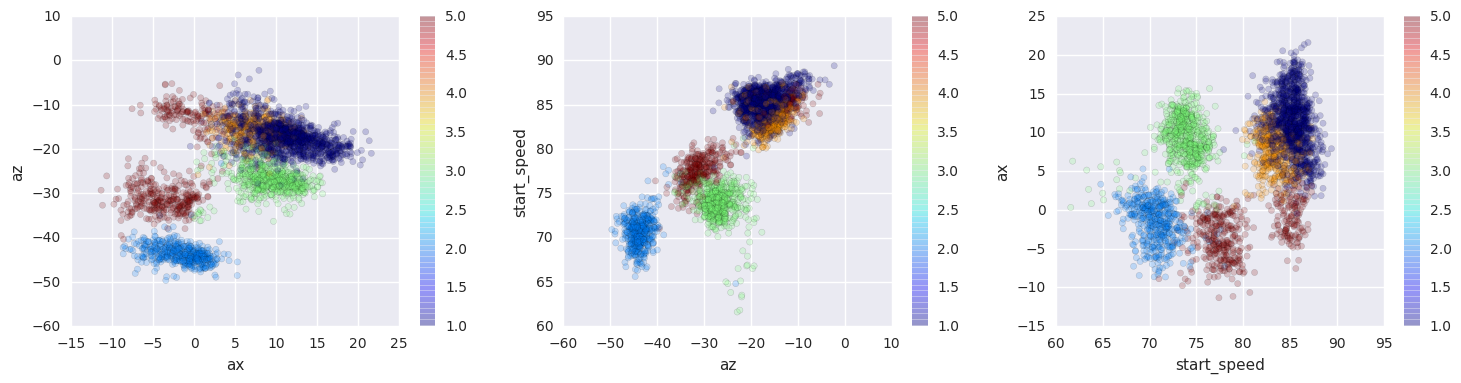

In [257]:
# get cluster labels
hlabel = hier.fcluster(hclust_pc3, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel)

We see that when we use three principal components, the five clusters are less convincing than when using four principal components. We can see the red cluster is split, and the orange cluster is hidden in the largest cluster.

Thus, we see that the quality of the clustering appears to be dependent on the number of principal components used in the analysis. While fewer principal components lead to data points being more condensed (and hence easier to cluster), less of the variance in the data is explained. On the other hand, while more principal components describe more variance in the data, the data points are more spread out (and hence less meaningful when clustered).

Overall, we see that using all trajectory features for classifying pitch types can be harmful to the clustering results. We can use PCA to decorrelate features and avoid the curse of dimensionality, but PCA tries to explain the variance of the data in a lower dimension, not help separate clusters in our data. While clustering in principal-component space can lead to reasonable clusters, the quality of the clustering appears highly dependent on the number of principal components kept. Thus, for the particular case of pitch classification, it appears best to cluster pitches using features based on our intuition (velocity and vertical/horizontal movements).

## Comparison of pitch classifications